In [20]:
#importing required modules and dependencies
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pickle

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

# Data Analysis

In [3]:
#load dataset and see few rows
df = pd.read_csv('/kaggle/input/suicide-watch/Suicide_Detection.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
#remove irrelevant column
df = df.drop('Unnamed: 0', axis=1)

#check for missing values
df.isnull().sum()

text     0
class    0
dtype: int64

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64


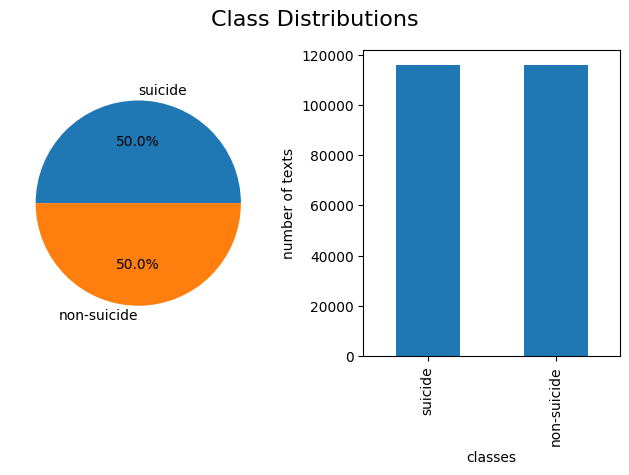

In [5]:
#check class distributions
class_counts = df['class'].value_counts()
print(class_counts)

#plots to visualise class distributions
fig, axs = plt.subplots(1, 2)

class_counts.plot(kind='pie', autopct='%1.1f%%', ax=axs[0])
axs[0].set_ylabel('')

class_counts.plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('classes')
axs[1].set_ylabel('number of texts')

fig.suptitle('Class Distributions', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
#check number of words in each text
df['len'] = df['text'].apply(lambda x: len(x.split(' ')))
df['len'].describe()

count    232074.000000
mean        131.546438
std         222.081581
min           1.000000
25%          26.000000
50%          60.000000
75%         154.000000
max       15632.000000
Name: len, dtype: float64

In [7]:
#a quantile is a statistical value that divides the dataset into intervals
#a quantile at 0.9 returns the value below which 90% of the data falls
for i in [0.8, 0.9, 0.95, 0.99, 0.995, 0.999]:
    print(i*100, '% :', df['len'].quantile(i))

80.0 % : 190.0
90.0 % : 317.0
95.0 % : 470.0
99.0 % : 960.0
99.5 % : 1264.6350000000093
99.9 % : 2198.8540000000503


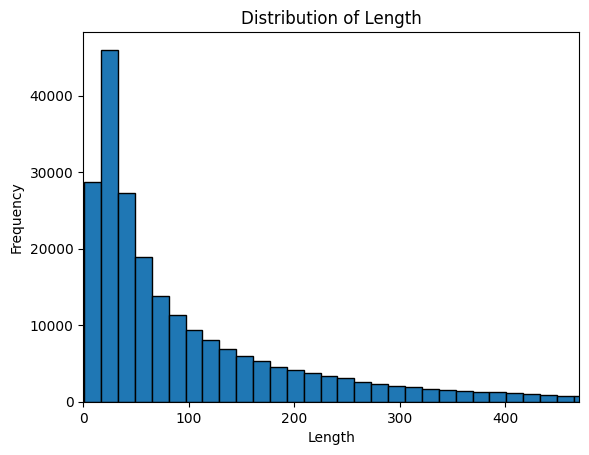

In [8]:
#visualize length distribution of texts
plt.hist(df['len'], bins=977, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Length')
plt.xlim(0, 470) #setting range on x-axis for plot to make sense, it visualises 95% of the dataset
plt.show()

# Data Preprocessing

In [9]:
#convert all text to lowercase
df['clean_text'] = df['text'].str.lower()

#remove URLs as they are not usually relevant to understand context of a text
df['clean_text'] = df['clean_text'].str.replace(r'https?://\S+', '', regex=True)

#remove numerical values and underscores as they are not contribting much to the meaning in our dataset
df['clean_text'] = df['clean_text'].str.replace(r'\d+', '', regex=True)
df['clean_text'] = df['clean_text'].str.replace('_', '', regex=False)

#remove punctuation and special characters
df['clean_text'] = df['clean_text'].str.replace('[^\w\s]', '', regex=True)
#`\w` matches alphanumeric characters and `\s` matches whitespaces
#replaces anything that is not one of the above with an empty string

#tokenize text for further cleansing
df['clean_text'] = df['clean_text'].str.split()

#remove stopwords (eg: is, an, the, for and various prepositions, conjuctions)
#as they do not add much value to meaning of the text
stop_words = set(stopwords.words('english'))
df['clean_text'] = df['clean_text'].apply(lambda row: [word for word in row if word not in stop_words])

#reduces words to their dictionary forms to retain meaning and context (cars, car, car's -> car)
lemmatizer = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(lambda row: [lemmatizer.lemmatize(word) for word in row])

# df.to_pickle('clean_data.pkl')
print(df.head())

                                                text        class  len  \
0  Ex Wife Threatening SuicideRecently I left my ...      suicide  143   
1  Am I weird I don't get affected by compliments...  non-suicide   27   
2  Finally 2020 is almost over... So I can never ...  non-suicide   26   
3          i need helpjust help me im crying so hard      suicide    9   
4  I’m so lostHello, my name is Adam (16) and I’v...      suicide  436   

                                          clean_text  
0  [ex, wife, threatening, suiciderecently, left,...  
1  [weird, dont, get, affected, compliment, comin...  
2  [finally, almost, never, hear, bad, year, ever...  
3              [need, helpjust, help, im, cry, hard]  
4  [im, losthello, name, adam, ive, struggling, y...  


# Feature Extraction

In [12]:
# df = pd.read_pickle('clean_data.pkl')

#splitting dataset train:test 80:20
X = df['clean_text'].apply(lambda row: ' '.join(row)) #required for feature extraction
y = df['class']

#perform label encoding of labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

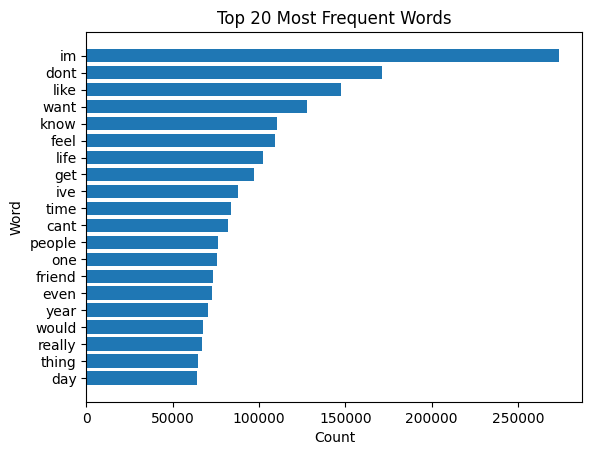

In [13]:
#bag of words (aka unigram) (BoW) representation (text as a vector of word frequencies)
count_vec_uni = CountVectorizer() #this tokenises and counts occurance of each tokens
X_train_uni = count_vec_uni.fit_transform(X_train)
X_test_uni = count_vec_uni.transform(X_test)

word_counts = X_train_uni.sum(axis=0).A1 #convert the matrix to a 1D array
words = count_vec_uni.get_feature_names_out() #get the list of words
#create a DataFrame for word frequencies
word_freq = pd.DataFrame({'word': words, 'count': word_counts})
word_freq = word_freq.sort_values(by='count', ascending=False)

#top 20 most frequent words
plt.barh(word_freq['word'].iloc[:20], word_freq['count'].iloc[:20])
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 20 Most Frequent Words')
plt.gca().invert_yaxis()
plt.show()

In [15]:
#TF-IDF (Term Frequency - Inverse Document Frequency) technique (assigns weights to words)
tfidf = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(185659, 1000)
(46415, 1000)


# Model Training

In [16]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print(confusion_matrix(y_test, y_pred))
with open('naive_bayes.pkl', 'wb') as f:
    pickle.dump(model, f)

Accuracy: 0.8665
Classification Report:
               precision    recall  f1-score   support

 non-suicide       0.92      0.80      0.86     23287
     suicide       0.82      0.93      0.87     23128

    accuracy                           0.87     46415
   macro avg       0.87      0.87      0.87     46415
weighted avg       0.87      0.87      0.87     46415

[[18722  4565]
 [ 1632 21496]]


In [17]:
model = Perceptron(random_state=42)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print(confusion_matrix(y_test, y_pred))
with open('perceptron.pkl', 'wb') as f:
    pickle.dump(model, f)

Accuracy: 0.8701
Classification Report:
               precision    recall  f1-score   support

 non-suicide       0.88      0.86      0.87     23287
     suicide       0.86      0.88      0.87     23128

    accuracy                           0.87     46415
   macro avg       0.87      0.87      0.87     46415
weighted avg       0.87      0.87      0.87     46415

[[19923  3364]
 [ 2664 20464]]


In [18]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print(confusion_matrix(y_test, y_pred))
with open('logistic.pkl', 'wb') as f:
    pickle.dump(model, f)

Accuracy: 0.9175
Classification Report:
               precision    recall  f1-score   support

 non-suicide       0.91      0.93      0.92     23287
     suicide       0.93      0.91      0.92     23128

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415

[[21587  1700]
 [ 2129 20999]]


In [21]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print(confusion_matrix(y_test, y_pred))
with open('decision_tree.pkl', 'wb') as f:
    pickle.dump(model, f)

Accuracy: 0.8419
Classification Report:
               precision    recall  f1-score   support

 non-suicide       0.83      0.85      0.84     23287
     suicide       0.85      0.83      0.84     23128

    accuracy                           0.84     46415
   macro avg       0.84      0.84      0.84     46415
weighted avg       0.84      0.84      0.84     46415

[[19879  3408]
 [ 3931 19197]]


In [22]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, verbose=3)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print(confusion_matrix(y_test, y_pred))
with open('random_forest.pkl', 'wb') as f:
    pickle.dump(model, f)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.0min


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished


Accuracy: 0.8936
Classification Report:
               precision    recall  f1-score   support

 non-suicide       0.90      0.89      0.89     23287
     suicide       0.89      0.90      0.89     23128

    accuracy                           0.89     46415
   macro avg       0.89      0.89      0.89     46415
weighted avg       0.89      0.89      0.89     46415

[[20701  2586]
 [ 2354 20774]]


In [24]:
model = MLPClassifier(hidden_layer_sizes=(256, 16), activation='relu', solver='adam', verbose=True,
                      learning_rate_init=0.001, max_iter=100, batch_size=1024, random_state=42,
                     early_stopping=True, learning_rate='adaptive')
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print(confusion_matrix(y_test, y_pred))
with open('mlp.pkl', 'wb') as f:
    pickle.dump(model, f)

Iteration 1, loss = 0.29502679
Validation score: 0.916083
Iteration 2, loss = 0.20961313
Validation score: 0.918776
Iteration 3, loss = 0.20281179
Validation score: 0.918453
Iteration 4, loss = 0.19362891
Validation score: 0.921362
Iteration 5, loss = 0.18152415
Validation score: 0.922331
Iteration 6, loss = 0.16856002
Validation score: 0.922116
Iteration 7, loss = 0.15468502
Validation score: 0.922170
Iteration 8, loss = 0.14030891
Validation score: 0.920177
Iteration 9, loss = 0.12591767
Validation score: 0.919853
Iteration 10, loss = 0.11147544
Validation score: 0.916783
Iteration 11, loss = 0.09667112
Validation score: 0.914952
Iteration 12, loss = 0.08222389
Validation score: 0.914952
Iteration 13, loss = 0.06954028
Validation score: 0.914090
Iteration 14, loss = 0.05696794
Validation score: 0.909404
Iteration 15, loss = 0.04743376
Validation score: 0.912313
Iteration 16, loss = 0.03894314
Validation score: 0.910589
Validation score did not improve more than tol=0.000100 for 10 co

In [ ]:
model = SVC(random_state=42, verbose=True)
model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)
print(confusion_matrix(y_test, y_pred))
with open('svm.pkl', 'wb') as f:
    pickle.dump(model, f)

[LibSVM]..................

In [19]:
unseen_text = "i am feeling low for past few days i cant take it anymore"
X_unseen = pd.Series([unseen_text])
X_unseen_tfidf = tfidf.transform(X_unseen)
print(model.predict(X_unseen_tfidf))

['suicide']
